In [1]:
import os
import time
import pandas as pd
import numpy as np
import re
import string
from scipy import stats
from random import sample
from collections import Counter
from PIL import Image

# Plotting Libraries
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_theme(context="notebook", style="darkgrid", palette="pastel")

# Geospacial Libraries
# import geobr
# import mapsmx as mp
# import plotly.express as px 
# import geopandas as gpd

# NLP Libraries
# import nltk
# from nltk.sentiment import SentimentIntensityAnalyzer
# from googletrans import Translator
# from wordcloud import WordCloud

# sklearn
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

# torch
# import torch
# import torchvision
# from torchvision import transforms, utils
# import torch.nn as nn
# import torch.optim as optim
# import torchvision.transforms as transforms
# from torchvision.io import read_image
# from torch.utils.data import Dataset, DataLoader, TensorDataset
# import torch.nn.functional as F
# from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# XGBoost
import xgboost as xgb

In [2]:
seed = 42

In [3]:
data_path = 'Brazilian-ecommerce/'
customers_df = pd.read_csv(data_path + "olist_customers_dataset.csv")
geolocation_df = pd.read_csv(data_path + "olist_geolocation_dataset.csv")
order_items_df = pd.read_csv(data_path + "olist_order_items_dataset.csv")
order_payments_df = pd.read_csv(data_path + "olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv(data_path + "olist_order_reviews_dataset.csv")
orders_df = pd.read_csv(data_path + "olist_orders_dataset.csv")
products_df = pd.read_csv(data_path + "olist_products_dataset.csv")
sellers_df = pd.read_csv(data_path + "olist_sellers_dataset.csv")
product_category_name_translation_df = pd.read_csv(data_path + "product_category_name_translation.csv")

In [4]:
# Merge data stored in various tables
full_df = orders_df.merge(order_reviews_df, on='order_id')\
                   .merge(order_payments_df, on='order_id')\
                   .merge(customers_df, on='customer_id')\
                   .merge(order_items_df, on='order_id')\
                   .merge(products_df, on='product_id')\
                   .merge(sellers_df, on='seller_id')
# Drop duplicates
full_df = full_df.drop_duplicates()

In [5]:
def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','dtypes']]
    summary['# Missing'] = df.isnull().sum().values    
    summary['# Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values

    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary
    
df_summary(full_df)

Dataset Shape: (117329, 39)


,Column,dtypes,# Missing,# Unique,Example,Entropy
0,order_id,object,0,97916,e481f51cbdc54678b7cc49136f2d6af7,16.43
1,customer_id,object,0,97916,9ef432eb6251297304e76186b10a928d,16.43
2,order_status,object,0,7,delivered,0.19
3,order_purchase_timestamp,object,0,97370,2017-10-02 10:56:33,16.42
4,order_approved_at,object,15,89533,2017-10-02 11:07:15,16.26
5,order_delivered_carrier_date,object,1235,80449,2017-10-04 19:55:00,16.02
6,order_delivered_customer_date,object,2471,95021,2017-10-10 21:25:13,16.39
7,order_estimated_delivery_date,object,0,449,2017-10-18 00:00:00,8.47
8,review_id,object,0,97708,a54f0611adc9ed256b57ede6b6eb5114,16.43
9,review_score,int64,0,5,4,1.77


In [6]:
datetime_columns = ['order_purchase_timestamp', 'order_approved_at', 
                    'order_delivered_carrier_date', 'order_delivered_customer_date', 
                    'order_estimated_delivery_date', 
                    'review_creation_date', 'review_answer_timestamp',
                    'shipping_limit_date']
full_df[datetime_columns] = full_df[datetime_columns].apply(pd.to_datetime)

In [7]:
full_df = full_df.rename(columns={'product_name_lenght': 'product_name_length',
                                   'product_description_lenght': 'product_description_length'
                                  })

In [8]:
numeric_columns = ['review_score', 'payment_sequential', 'payment_installments',
                   'payment_value', 'price', 'freight_value', 'product_name_length',
                   'product_description_length', 'product_photos_qty', 'product_weight_g',
                   'product_length_cm', 'product_height_cm', 'product_width_cm']
numeric_df = full_df[numeric_columns]
corr = numeric_df.corr()

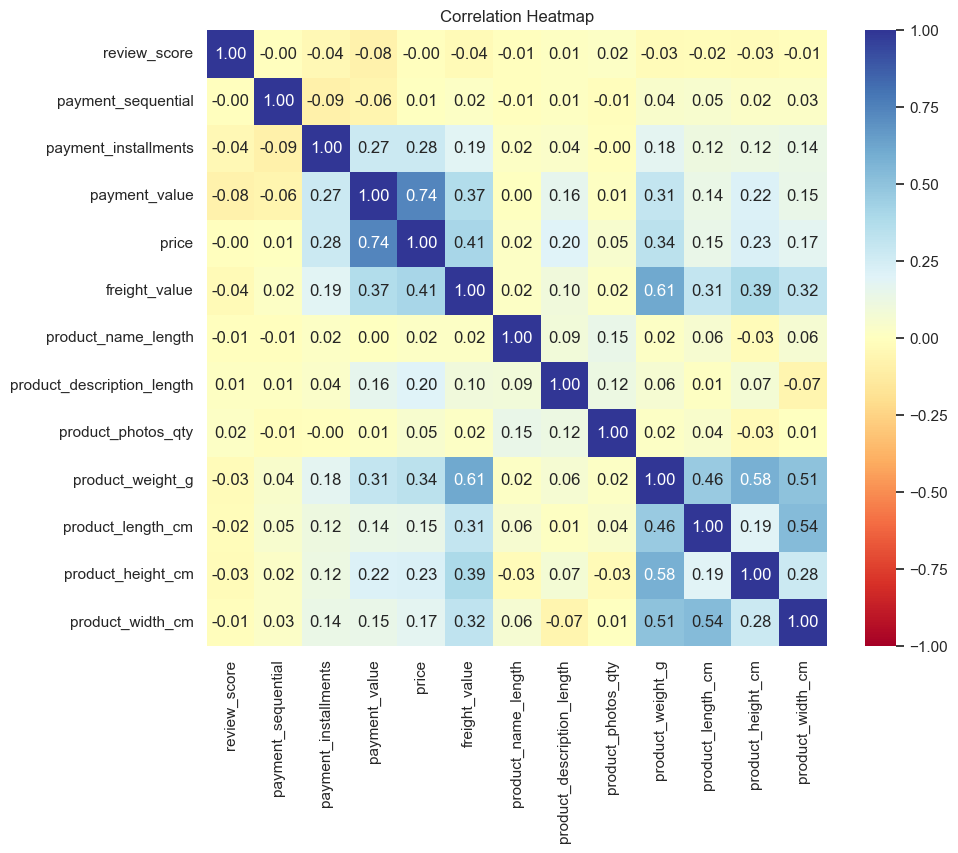

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='RdYlBu', norm=plt.Normalize(-1,1), annot=True, fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

In [10]:
corr_review_score = corr.loc[(corr['review_score'] > 0.2) | (corr['review_score'] <= -0.2)]
corr_review_score

,review_score,payment_sequential,payment_installments,payment_value,price,freight_value,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
review_score,1.0,-0.004634,-0.042279,-0.082404,-0.004515,-0.037076,-0.006323,0.010354,0.022266,-0.028641,-0.020441,-0.026409,-0.010743


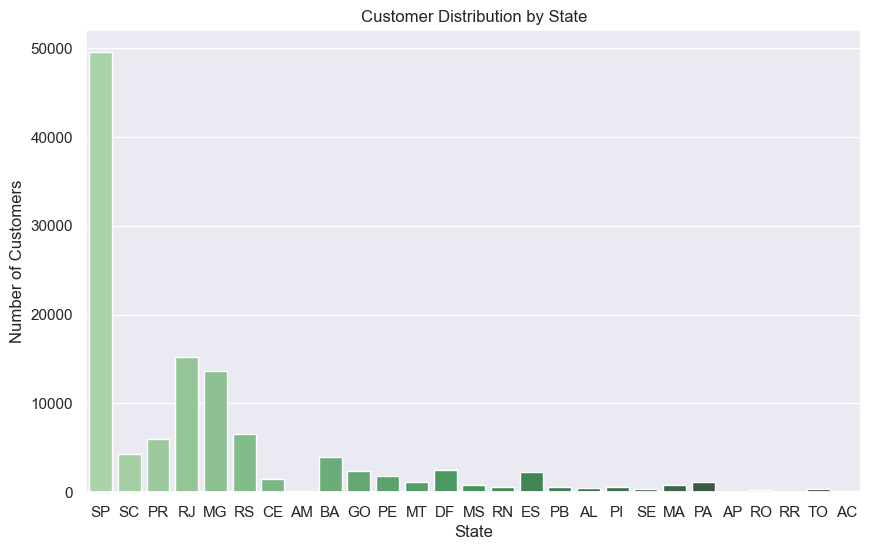

In [11]:
customer_columns = ['order_id', 'customer_id', 'customer_state']

plt.figure(figsize=(10, 6))
sns.countplot(x='customer_state', data=full_df[customer_columns], palette=("Greens_d"))
plt.title('Customer Distribution by State')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.show()

In [12]:
shipped_review_mean = full_df[full_df['order_status'] == 'shipped']['review_score'].mean()
canceled_review_mean = full_df[full_df['order_status'] == 'canceled']['review_score'].mean()
invoiced_review_mean = full_df[full_df['order_status'] == 'invoiced']['review_score'].mean()
processing_review_mean = full_df[full_df['order_status'] == 'processing']['review_score'].mean()
unavailable_review_mean = full_df[full_df['order_status'] == 'unavailable']['review_score'].mean()
approved_review_mean = full_df[full_df['order_status'] == 'approved']['review_score'].mean()

# Round the mean values to two decimal places
shipped_review_mean = round(shipped_review_mean, 2)
canceled_review_mean = round(canceled_review_mean, 2)
invoiced_review_mean = round(invoiced_review_mean, 2)
processing_review_mean = round(processing_review_mean, 2)
unavailable_review_mean = round(unavailable_review_mean, 2)
approved_review_mean = round(approved_review_mean, 2)

print('- Average Review Score for Non-Delivered Statuses -')
print(f'The mean review score for "shipped" order is {shipped_review_mean}')
print(f'The mean review score for "canceled" order is {canceled_review_mean}')
print(f'The mean review score for "invoiced" order is {invoiced_review_mean}')
print(f'The mean review score for "processing" order is {processing_review_mean}')
print(f'The mean review score for "unavailable" order is {unavailable_review_mean}')
print(f'The mean review score for "approved" order is {approved_review_mean}')


- Average Review Score for Non-Delivered Statuses -
The mean review score for "shipped" order is 1.98
The mean review score for "canceled" order is 1.59
The mean review score for "invoiced" order is 1.65
The mean review score for "processing" order is 1.35
The mean review score for "unavailable" order is 1.57
The mean review score for "approved" order is 2.0


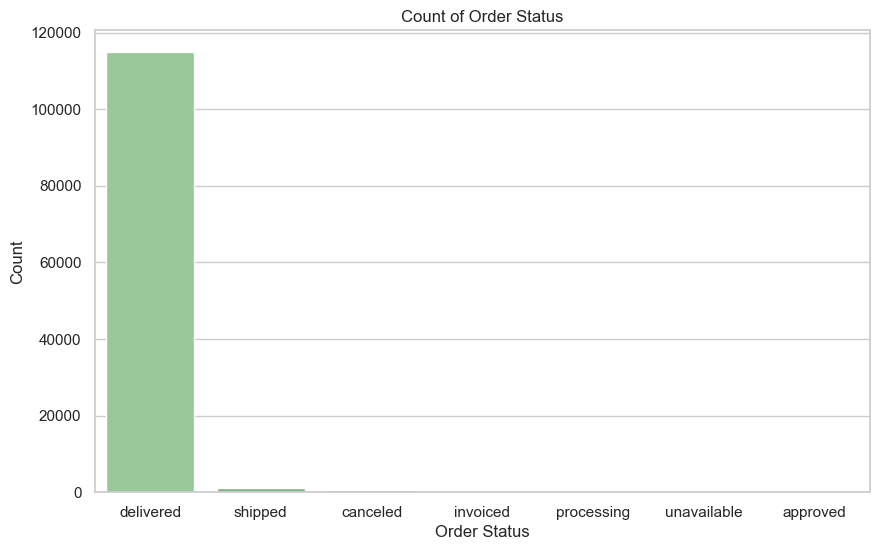

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.countplot(x="order_status", data=full_df, palette="Greens_d")

plt.title("Count of Order Status")
plt.xlabel("Order Status")
plt.ylabel("Count")

plt.show()

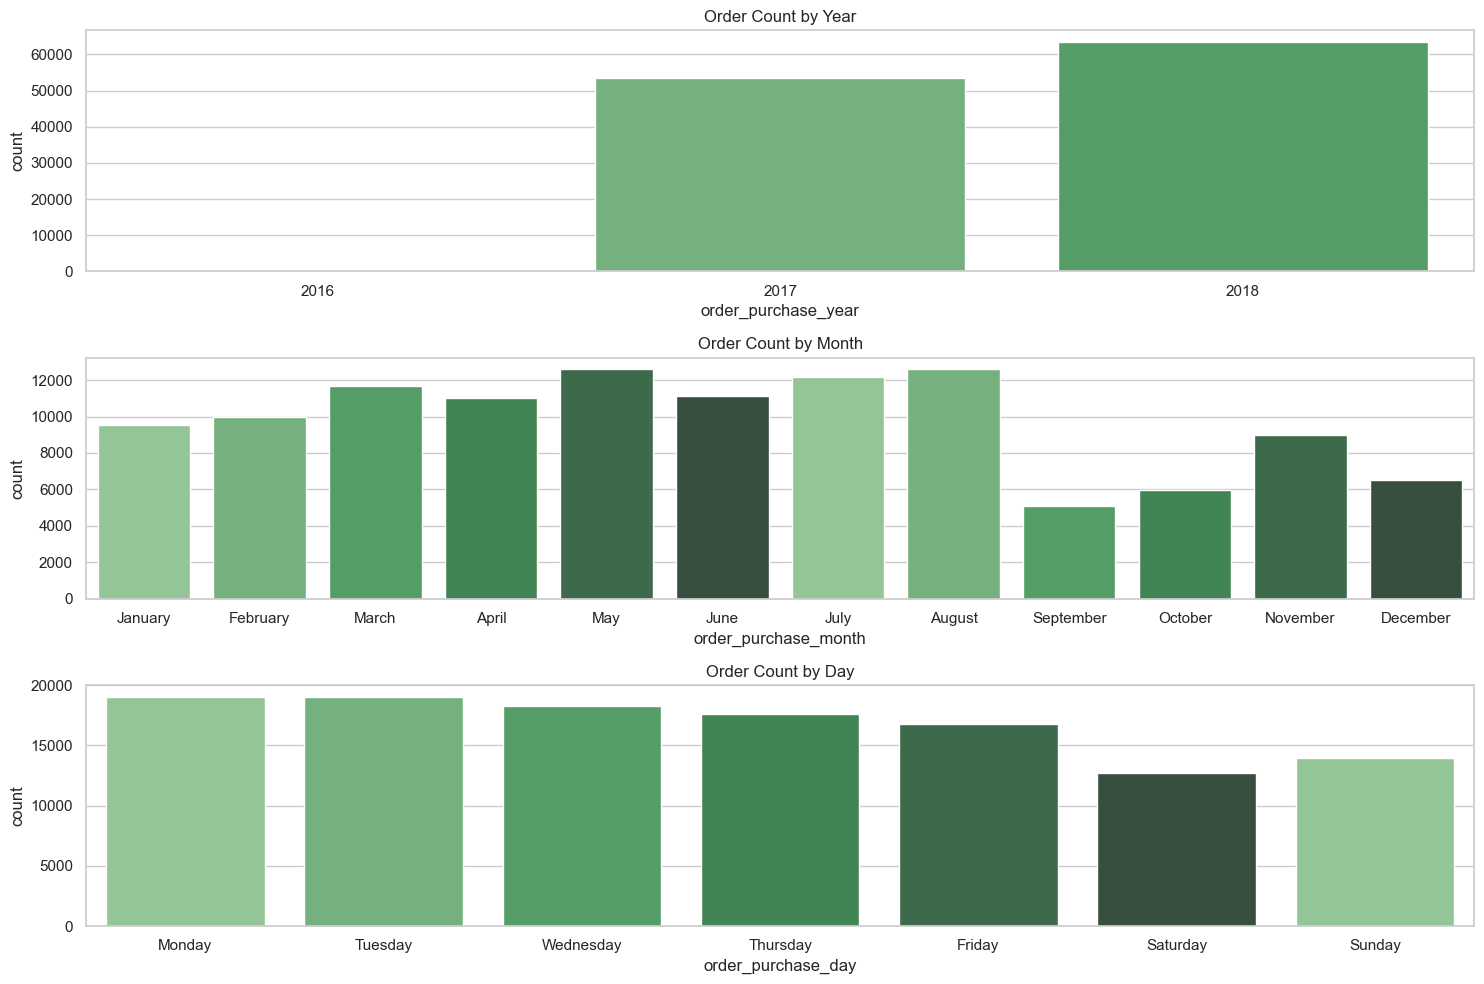

In [14]:
full_df['order_purchase_timestamp'] = pd.to_datetime(full_df['order_purchase_timestamp'])

# Extract Year, Month, and Day of the week
full_df['order_purchase_year'] = full_df['order_purchase_timestamp'].dt.year
full_df['order_purchase_month'] = full_df['order_purchase_timestamp'].dt.month
full_df['order_purchase_day'] = full_df['order_purchase_timestamp'].dt.dayofweek  # 0 for Monday, 6 for Sunday

# Set the day names for better visualization
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
full_df['order_purchase_day'] = full_df['order_purchase_day'].map(lambda x: day_names[x])

# Set the month names for better visualization
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
full_df['order_purchase_month'] = full_df['order_purchase_month'].map(lambda x: month_names[x - 1])  # Subtract 1 as months are 1-indexed

# Define a custom color palette
custom_palette = sns.color_palette("Greens_d")

# Plot count for Year, Month, and Day
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
sns.countplot(x='order_purchase_year', data=full_df, palette=custom_palette)
plt.title('Order Count by Year')

plt.subplot(3, 1, 2)
sns.countplot(x='order_purchase_month', data=full_df, order=month_names, palette=custom_palette)
plt.title('Order Count by Month')

plt.subplot(3, 1, 3)
sns.countplot(x='order_purchase_day', data=full_df, order=day_names, palette=custom_palette)
plt.title('Order Count by Day')

plt.tight_layout()
plt.show()


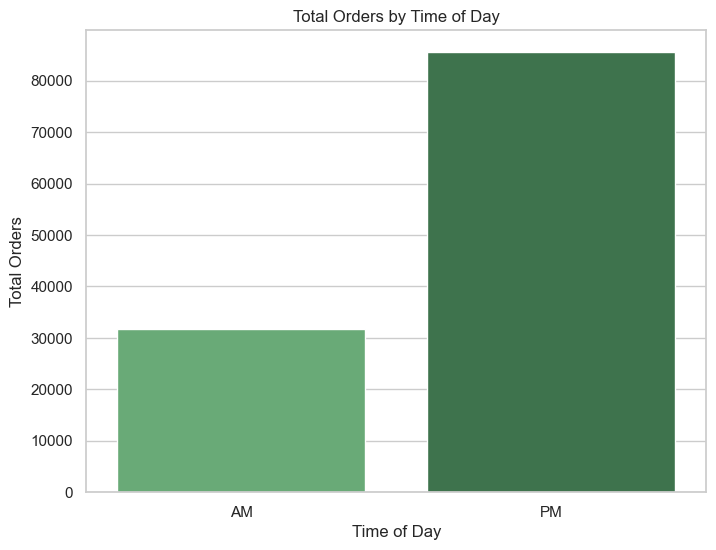

In [15]:
full_df['order_purchase_timestamp'] = pd.to_datetime(full_df['order_purchase_timestamp'])

# Extract the hour of the day
full_df['order_purchase_hour'] = full_df['order_purchase_timestamp'].dt.hour

# Categorize the time of day into AM or PM
full_df['time_of_day'] = full_df['order_purchase_hour'].apply(lambda x: 'AM' if 0 <= x < 12 else 'PM')

# Plot total orders by time of day
plt.figure(figsize=(8, 6))
sns.countplot(x='time_of_day', data=full_df, palette="Greens_d")
plt.title('Total Orders by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Total Orders')
plt.show()





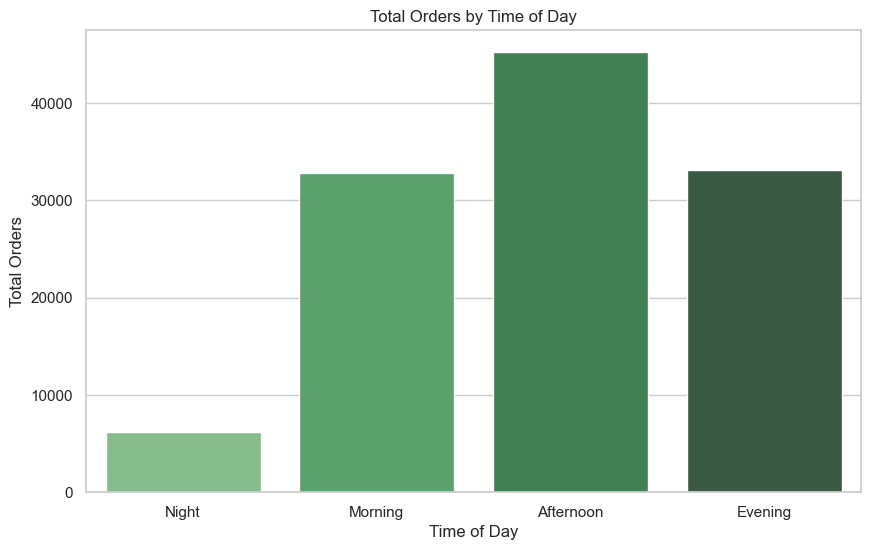

In [16]:
full_df['order_purchase_timestamp'] = pd.to_datetime(full_df['order_purchase_timestamp'])

# Extract the hour of the day
full_df['order_purchase_hour'] = full_df['order_purchase_timestamp'].dt.hour

# Categorize the time of day
full_df['time_of_day'] = pd.cut(
    full_df['order_purchase_hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    include_lowest=True
)

# Plot total orders by time of day
plt.figure(figsize=(10, 6))
sns.countplot(x='time_of_day', data=full_df, palette="Greens_d")
plt.title('Total Orders by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Total Orders')
plt.show()


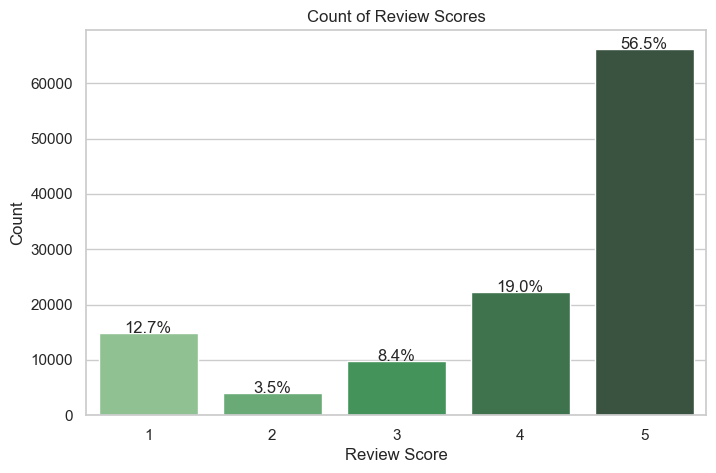

In [17]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='review_score', data=full_df, palette="Greens_d")
plt.title('Count of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Count')

# Add data labels on top of each bar
total = len(full_df)  # Total number of entries
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, f'{height/total:.1%}', ha="center")

plt.show()

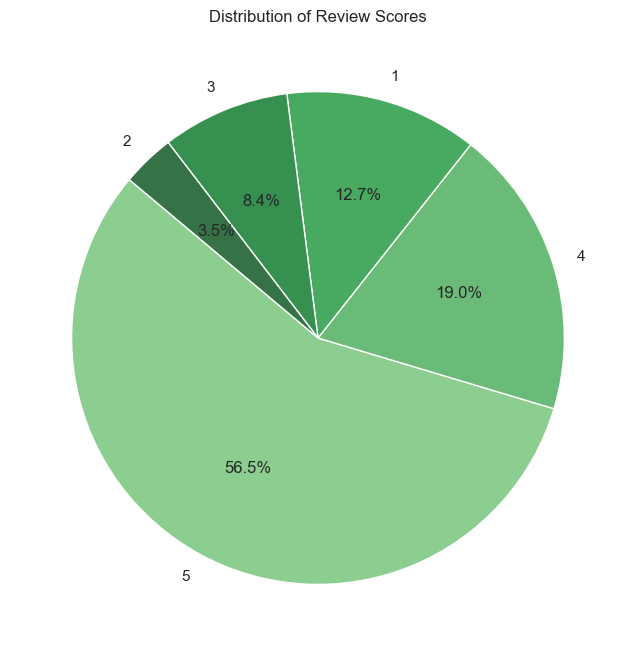

In [18]:
import matplotlib.pyplot as plt

# Calculate the percentage of each review score
score_counts = full_df['review_score'].value_counts()
percentages = (score_counts / len(full_df)) * 100

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Greens_d"))
plt.title('Distribution of Review Scores')
plt.show()


In [19]:
feature_df = full_df

In [20]:
price_median = feature_df['price'].median();
feature_df.loc[feature_df['price'] >= price_median, "price_factor"] = 1
feature_df.loc[feature_df['price'] < price_median, "price_factor"] = 0

In [21]:
freight_value_median = feature_df['freight_value'].median();
feature_df.loc[feature_df['freight_value'] >= freight_value_median, "freight_value_factor"] = 1
feature_df.loc[feature_df['freight_value'] < freight_value_median, "freight_value_factor"] = 0

In [22]:
feature_df.loc[feature_df['order_status'] == 'delivered', "if_delivered"] = 1
feature_df.loc[feature_df['order_status'] != 'delivered', "if_delivered"] = 0

In [23]:
# Check how many rows in non_delivered records don't have data in `order_delivered_customer_date`
non_delivered = feature_df[feature_df['if_delivered'] == 0]
nan_delivered_customer_count = non_delivered[non_delivered['order_delivered_customer_date'].isnull()]['order_id'].count()
print(f'There are {nan_delivered_customer_count} rows isnull in order_delivered_customer_date column for all non_delivered rows')

There are 2463 rows isnull in order_delivered_customer_date column for all non_delivered rows


In [24]:
feature_df.loc[feature_df['order_delivered_customer_date'].isnull(), "order_delivered_customer_date"] = feature_df['order_estimated_delivery_date']

In [25]:
# Keep the difference in days to the column
feature_df['actual_est_delivery_diff'] = (feature_df['order_estimated_delivery_date'] - feature_df['order_delivered_customer_date']).dt.days

In [26]:
feature_df['delivery_duration'] = (feature_df['order_delivered_customer_date'] - feature_df['order_purchase_timestamp']).dt.days

In [27]:
feature_df.loc[feature_df['product_photos_qty'].isnull(), "product_photos_qty"] = 0
feature_df.loc[feature_df['product_description_length'].isnull(), "product_description_length"] = 0
feature_df = feature_df.dropna(subset=['product_weight_g'])

In [28]:
feature_df = feature_df.dropna(subset=['product_name_length'])

In [29]:
feature_df = feature_df.merge(product_category_name_translation_df, on='product_category_name')

In [30]:
feature_df.dropna(axis=1, inplace=True)

In [31]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115608 entries, 0 to 115607
Data columns (total 46 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115608 non-null  object        
 1   customer_id                    115608 non-null  object        
 2   order_status                   115608 non-null  object        
 3   order_purchase_timestamp       115608 non-null  datetime64[ns]
 4   order_delivered_customer_date  115608 non-null  datetime64[ns]
 5   order_estimated_delivery_date  115608 non-null  datetime64[ns]
 6   review_id                      115608 non-null  object        
 7   review_score                   115608 non-null  int64         
 8   review_creation_date           115608 non-null  datetime64[ns]
 9   review_answer_timestamp        115608 non-null  datetime64[ns]
 10  payment_sequential             115608 non-null  int64         
 11  

In [32]:
balance_df = feature_df

In [33]:
# Define the mapping
mapping = {1: 0.0, 2: 0.0, 3: 0.5, 4: 0.5, 5: 1.0}

# Replace values in the 'review_score' column
balance_df['review_score'] = balance_df['review_score'].replace(mapping)


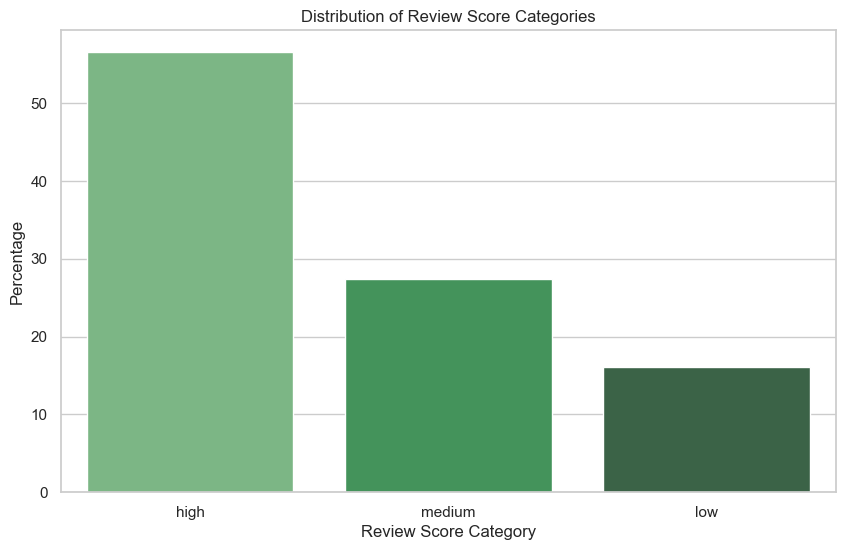

In [34]:
# Map review scores to 'low', 'medium', and 'high'
mm = balance_df
mm['review_score_category'] = mm['review_score'].map({0.0: 'low', 0.5: 'medium', 1.0: 'high'})

# Count the occurrences of each category
score_category_counts = mm['review_score_category'].value_counts()
percentages = (score_category_counts / len(mm)) * 100

# Plot a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=percentages.index, y=percentages, palette="Greens_d")
plt.title('Distribution of Review Score Categories')
plt.xlabel('Review Score Category')
plt.ylabel('Percentage')
plt.show()


In [ ]:
balance_df = balance_df.drop('review_score_category', axis=1)

In [53]:
y = balance_df['review_score']
x = balance_df.drop('review_score', axis=1) 

In [54]:
from sklearn.preprocessing import LabelEncoder
col = x.columns

label_encoder = LabelEncoder()
for cols in col:
    x[cols] = label_encoder.fit_transform(x[cols])

x.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_creation_date,review_answer_timestamp,payment_sequential,...,order_purchase_month,order_purchase_day,order_purchase_hour,time_of_day,price_factor,freight_value_factor,if_delivered,actual_est_delivery_diff,delivery_duration,product_category_name_english
0,86345,59988,2,26556,25401,205,62358,310,25818,0,...,10,1,10,2,0,0,1,119,8,49
1,86345,59988,2,26556,25401,205,62358,310,25818,2,...,10,1,10,2,0,0,1,119,8,49
2,86345,59988,2,26556,25401,205,62358,310,25818,1,...,10,1,10,2,0,0,1,119,8,49
3,7030,61152,2,20096,18356,170,68112,257,18795,0,...,1,5,18,0,0,0,1,121,2,49
4,5482,14699,2,18374,16842,161,83102,246,17171,0,...,1,6,18,0,0,0,1,119,5,49


In [55]:
from sklearn.preprocessing import MinMaxScaler
col = x.columns
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Apply Min-Max scaling to each numerical column
x[col]= scaler.fit_transform(x[col])
x.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_creation_date,review_answer_timestamp,payment_sequential,...,order_purchase_month,order_purchase_day,order_purchase_hour,time_of_day,price_factor,freight_value_factor,if_delivered,actual_est_delivery_diff,delivery_duration,product_category_name_english
0,0.894637,0.621547,0.333333,0.276662,0.269982,0.457589,0.647425,0.491284,0.268487,0.000000,...,0.909091,0.166667,0.434783,0.666667,0.0,0.0,1.0,0.616580,0.055944,0.7
1,0.894637,0.621547,0.333333,0.276662,0.269982,0.457589,0.647425,0.491284,0.268487,0.071429,...,0.909091,0.166667,0.434783,0.666667,0.0,0.0,1.0,0.616580,0.055944,0.7
2,0.894637,0.621547,0.333333,0.276662,0.269982,0.457589,0.647425,0.491284,0.268487,0.035714,...,0.909091,0.166667,0.434783,0.666667,0.0,0.0,1.0,0.616580,0.055944,0.7
3,0.072839,0.633608,0.333333,0.209362,0.195102,0.379464,0.707165,0.407290,0.195453,0.000000,...,0.090909,0.833333,0.782609,0.000000,0.0,0.0,1.0,0.626943,0.013986,0.7
4,0.056800,0.152299,0.333333,0.191422,0.179010,0.359375,0.862797,0.389857,0.178565,0.000000,...,0.090909,1.000000,0.782609,0.000000,0.0,0.0,1.0,0.616580,0.034965,0.7


In [56]:
model_df = pd.concat([x, y], axis=1)

In [57]:
model_df['review_score'] = model_df['review_score'].astype(float)
# model_df = balance_df

In [58]:
model_df.shape

(115608, 46)

In [59]:
y


0         0.5
1         0.5
2         0.5
3         0.5
4         1.0
         ... 
115603    1.0
115604    1.0
115605    1.0
115606    1.0
115607    1.0
Name: review_score, Length: 115608, dtype: float64

In [60]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115608 entries, 0 to 115607
Data columns (total 46 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115608 non-null  float64
 1   customer_id                    115608 non-null  float64
 2   order_status                   115608 non-null  float64
 3   order_purchase_timestamp       115608 non-null  float64
 4   order_delivered_customer_date  115608 non-null  float64
 5   order_estimated_delivery_date  115608 non-null  float64
 6   review_id                      115608 non-null  float64
 7   review_creation_date           115608 non-null  float64
 8   review_answer_timestamp        115608 non-null  float64
 9   payment_sequential             115608 non-null  float64
 10  payment_type                   115608 non-null  float64
 11  payment_installments           115608 non-null  float64
 12  payment_value                 

In [61]:
# Create a subset with 20 records
test_df = model_df.sample(n=20, random_state=42)  # You can use any random_state for reproducibility

# Save the subset to a new CSV file (adjust the file path as needed)
test_df.to_csv('test_df.csv', index=False)
test_df.head(13)

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_creation_date,review_answer_timestamp,payment_sequential,...,order_purchase_day,order_purchase_hour,time_of_day,price_factor,freight_value_factor,if_delivered,actual_est_delivery_diff,delivery_duration,product_category_name_english,review_score
80928,0.972242,0.249176,0.333333,0.485639,0.540793,0.689732,0.519296,0.702060,0.539273,0.0,...,0.166667,0.565217,0.000000,1.0,1.0,1.0,0.735751,0.272727,0.228571,0.5
109180,0.282208,0.155749,0.333333,0.780512,0.766889,0.796875,0.038103,0.841521,0.764790,0.0,...,1.000000,0.565217,0.000000,0.0,0.0,1.0,0.647668,0.041958,0.757143,0.5
12492,0.396119,0.976221,0.333333,0.104337,0.093395,0.256696,0.390845,0.274168,0.092428,0.0,...,0.166667,0.478261,0.666667,1.0,0.0,1.0,0.652850,0.020979,0.285714,1.0
31032,0.063328,0.305945,0.333333,0.837124,0.831948,0.866071,0.524819,0.890650,0.827997,0.0,...,0.000000,0.391304,0.666667,1.0,1.0,1.0,0.720207,0.048951,0.557143,1.0
96096,0.680865,0.667333,0.333333,0.852355,0.849804,0.857143,0.900900,0.901743,0.847859,0.0,...,0.000000,0.608696,0.000000,1.0,0.0,1.0,0.663212,0.048951,0.100000,1.0
68686,0.944091,0.988841,0.333333,0.847688,0.840515,0.854911,0.296697,0.896989,0.841058,0.0,...,1.000000,0.521739,0.666667,0.0,1.0,1.0,0.663212,0.041958,0.214286,0.5
30813,0.593344,0.163582,0.333333,0.032879,0.032099,0.136161,0.184900,0.171157,0.030002,0.0,...,0.166667,0.652174,0.000000,0.0,0.0,1.0,0.606218,0.076923,0.557143,0.5
78093,0.684004,0.425741,0.333333,0.850907,0.848912,0.872768,0.144191,0.901743,0.847579,0.0,...,0.666667,0.826087,0.333333,0.0,1.0,1.0,0.709845,0.048951,0.971429,0.5
64576,0.656640,0.947531,0.333333,0.815558,0.795534,0.834821,0.421411,0.866878,0.792899,0.0,...,0.833333,0.869565,0.333333,0.0,0.0,1.0,0.689119,0.006993,0.371429,1.0
49137,0.781431,0.478936,0.333333,0.026191,0.030738,0.140625,0.135739,0.169572,0.029076,0.0,...,0.000000,0.608696,0.000000,1.0,1.0,1.0,0.632124,0.132867,0.614286,1.0


In [62]:
import gym
from gym import spaces
import pandas as pd
import numpy as np


class CustomEnv(gym.Env):
    def __init__(self, dataframe):
        super(CustomEnv, self).__init__()

        self.dataframe = dataframe
        self.state_dim = len(dataframe.columns) - 1  # Exclude the target column 'review_score'

        # Define action and observation space
        self.action_space = spaces.Discrete(n=3)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.state_dim,), dtype=np.float32)

        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return self._get_observation()


    def step(self, action):
        # Simulate taking action and observe the next state and reward from your dataset
        next_state, reward, done = self._take_action(action)
        return next_state, reward, done, {}

    def _get_observation(self):
        if self.current_step < len(self.dataframe):
            return self.dataframe.iloc[self.current_step, :-1].values
        else:
            print("End of dataset reached.")
            return np.zeros(self.state_dim)
        
    def _take_action(self, action):
        # Simulate taking action and observe the next state and reward from your dataset
        reward = self.dataframe.iloc[self.current_step, -1]  # 'review_score'

        # Move to the next step
        self.current_step += 1

        # Check if we reached the end of the dataset
        done = self.current_step == len(self.dataframe)
        if done:
            self.current_step = 0  # Reset to the beginning for continuous testing

        return self._get_observation(), reward, done
    

In [63]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from collections import deque
import random
from tensorflow.keras import layers, models, optimizers


# Define the Deep Q-Network (DQN) model
def build_model(state_dim, num_actions):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(state_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_actions, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

# Define the Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)
        if len(self.buffer) > self.buffer_size:
            self.buffer.popleft()

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
#         print("Batch before unpacking:", batch)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)


    def __len__(self):
        return len(self.buffer)
    
# Define the epsilon-greedy strategy
def epsilon_greedy(action_values, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(action_values))
    else:
        return np.argmax(action_values)

# Define the training process
def train_dqn(model, replay_buffer, batch_size, gamma=0.99):
    if len(replay_buffer) < batch_size:
        return

    mini_batch = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states, done = zip(*mini_batch)

    # Ensure all states have the same size along axis 1
    max_state_size = max(s.shape[1] if len(s.shape) > 1 else 0 for s in states)
    states = np.vstack([np.pad(s, ((0, 0), (0, max_state_size - (s.shape[1] if len(s.shape) > 1 else 0))), mode='constant', constant_values=0) for s in states])

    # Similarly, ensure all next_states have the same size along axis 1
    max_next_state_size = max(s.shape[1] if s is not None and len(s.shape) > 1 else 0 for s in next_states)
    next_states = np.vstack([np.pad(s, ((0, 0), (0, max_next_state_size - (s.shape[1] if s is not None and len(s.shape) > 1 else 0))), mode='constant', constant_values=0) if s is not None else np.zeros((1, max_next_state_size)) for s in next_states])

    targets = model.predict(states)
    next_q_values = model.predict(next_states)

    for i in range(batch_size):
        if done[i]:
            targets[i, actions[i]] = rewards[i]
        else:
            targets[i, actions[i]] = rewards[i] + gamma * np.max(next_q_values[i])

    model.fit(states, targets, epochs=1, verbose=0)

# Define the environment interaction and training loop
def train_dqn_with_environment(model, env, replay_buffer, num_episodes, batch_size, epsilon_decay=0.995):
    epsilon = 1.0

    for episode in range(num_episodes):
        state = env.reset()
        state = np.reshape(state, [1, -1])
        

        total_reward = 0

        while True:
            
            # Choose action using epsilon-greedy strategy
            action_values = model.predict(state.astype(np.float32))
            action = epsilon_greedy(action_values[0], epsilon)

            # Take action and observe the next state and reward
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, -1])

            # Add the experience to the replay buffer
            replay_buffer.add((state, action, reward, next_state, None if done else next_state))
            

            # Train the DQN
            train_dqn(model, replay_buffer, batch_size)

            total_reward += float(reward)
            state = next_state

            if done:
                break

        # Decay epsilon
        epsilon *= epsilon_decay
        epsilon = max(0.1, epsilon)  # Ensure epsilon doesn't go below 0.1

        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}")


# Carry out testing
state_dim = 45
num_actions = 3  
num_episodes = 1000
batch_size = 5
buffer_size = 1000  
replay_buffer = ReplayBuffer(buffer_size)

# enter your environment
env = CustomEnv(test_df)

model = build_model(state_dim, num_actions)
replay_buffer = ReplayBuffer(buffer_size)

# train_dqn_with_environment(model, env, replay_buffer, num_episodes, batch_size)


In [ ]:
import numpy as np
import pandas as pd
from collections import deque
import random
from tensorflow.keras import layers, models
import gym
from gym import spaces

# enter your environment
env = CustomEnv(test_df)

model = build_model(state_dim, num_actions)

# Function to perform user testing
def user_testing(model, env, num_tests=20):
    # Initialize the environment and replay buffer
    state_dim = 45
    num_actions = 3
    buffer_size = 1000
    replay_buffer = ReplayBuffer(buffer_size)

    # Counter for successful recommendations
    successful_recommendations = 0

    for test in range(num_tests):
        print(f"\nTest {test + 1}")

        # Reset the environment for each test
        state = env.reset()
        state = np.reshape(state, [1, -1])

        # Simulate user interaction
        while True:
            # Choose action using epsilon-greedy strategy
            action_values = model.predict(state.astype(np.float32))
            action = np.argmax(action_values[0])

            # Take action and observe the next state and reward
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, -1])

            # Print recommended product based on the action
            recommended_product = env.dataframe.iloc[env.current_step - 1]['product_name_length']
            print(f"Recommended Product: {recommended_product}")

            # Add the experience to the replay buffer
            replay_buffer.add((state, action, reward, next_state, None if done else next_state))

            state = next_state

            if done:
                # Simulation ended (end of dataset)
                print("End of dataset reached.")
                break

        # Check if the simulated recommendation was successful (reward > 0)
        if reward > 0:
            successful_recommendations += 1

    # Print summary
    print(f"\nSuccessful Recommendations: {successful_recommendations}/{num_tests}")

# Carry out user testing
user_testing(model, env)


In [68]:
# Test case of Product Name
# Note: 
test_df['product_name_length']

80928     0.692308
109180    0.830769
12492     0.600000
31032     0.800000
96096     0.753846
68686     0.800000
30813     0.692308
78093     0.646154
64576     0.784615
49137     0.461538
103310    0.784615
6143      0.615385
42910     0.846154
8535      0.753846
50647     0.769231
10405     0.569231
38161     0.476923
115508    0.815385
110910    0.584615
14474     0.846154
Name: product_name_length, dtype: float64